In [2]:
import json
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set paths
datasets_dir = '../../../datasets'
clevr_dir = os.path.join(datasets_dir,'CLEVR/CLEVR_v1.0')
clevrx_dir = os.path.join(datasets_dir,'CLEVR-X')

questions_dir = os.path.join(clevr_dir, 'questions')
image_dir = os.path.join(clevr_dir, 'images')
scence_dir = os.path.join(clevr_dir, 'scenes')

train_image_dir = os.path.join(image_dir, 'train')
test_image_dir = os.path.join(image_dir, 'test')
val_image_dir = os.path.join(image_dir, 'val')

NUM_TRAIN_IMAGES = len(os.listdir(train_image_dir))
NUM_TEST_IMAGES = len(os.listdir(test_image_dir))
NUM_VAL_IMAGES = len(os.listdir(val_image_dir))

In [2]:
with open(os.path.join(clevrx_dir, 'CLEVR_train_explanations_v0.7.10.json')) as f:
    explain_train = json.load(f)
with open(os.path.join(clevrx_dir, 'CLEVR_val_explanations_v0.7.10.json')) as f:
    explain_val = json.load(f)
    
explain_train = explain_train['questions']
explain_val = explain_val['questions']

In [4]:
explain_train[0]

{'image_index': 0,
 'program': [{'inputs': [], 'function': 'scene', 'value_inputs': []},
  {'inputs': [0], 'function': 'filter_size', 'value_inputs': ['large']},
  {'inputs': [1], 'function': 'filter_color', 'value_inputs': ['green']},
  {'inputs': [2], 'function': 'count', 'value_inputs': []},
  {'inputs': [], 'function': 'scene', 'value_inputs': []},
  {'inputs': [4], 'function': 'filter_size', 'value_inputs': ['large']},
  {'inputs': [5], 'function': 'filter_color', 'value_inputs': ['purple']},
  {'inputs': [6], 'function': 'filter_material', 'value_inputs': ['metal']},
  {'inputs': [7], 'function': 'filter_shape', 'value_inputs': ['cube']},
  {'inputs': [8], 'function': 'count', 'value_inputs': []},
  {'inputs': [3, 9], 'function': 'greater_than', 'value_inputs': []}],
 'question_index': 0,
 'image_filename': 'CLEVR_train_000000.png',
 'question_family_index': 2,
 'split': 'train',
 'answer': 'yes',
 'question': 'Are there more big green things than large purple shiny cubes?',
 'fa

## Check data after translation

In [3]:
with open(os.path.join(clevrx_dir, 'CLEVR-X_train_translated.json')) as f:
    data = json.load(f)
data = data['questions']
print(len(data))

699964


In [4]:
# check every item has 'answer_vi_ggtrans', 'question_vi_ggtrans', 'factual_explanation_vi_ggtrans' (an array of strings)
for i in range(len(data)):
    assert 'answer_vi_ggtrans' in data[i]
    assert 'question_vi_ggtrans' in data[i]
    assert 'factual_explanation_vi_ggtrans' in data[i]
    assert isinstance(data[i]['answer_vi_ggtrans'], str)
    assert isinstance(data[i]['question_vi_ggtrans'], str)
    assert isinstance(data[i]['factual_explanation_vi_ggtrans'], list)
    for j in range(len(data[i]['factual_explanation_vi_ggtrans'])):
        assert isinstance(data[i]['factual_explanation_vi_ggtrans'][j], str)
        
print('All items have "answer_vi_ggtrans", "question_vi_ggtrans", "factual_explanation_vi_ggtrans"')

All items have "answer_vi_ggtrans", "question_vi_ggtrans", "factual_explanation_vi_ggtrans"


## Check vocab, word frequency, and word length

In [5]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
import string
from nltk.corpus import stopwords
# Download NLTK data if not already downloaded
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

def clean_and_tokenize(text):
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords (optional, comment out if you want to keep stopwords)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def build_vocab(data, key):
    vocab = Counter()
    for item in tqdm(data, desc=f"Building {key} vocabulary"):
        if key == 'answer':
            vocab.update(clean_and_tokenize(item[key]))
        else:
            text = item[key] if key == 'question' else ' '.join(item[key])
            vocab.update(clean_and_tokenize(text))
    return vocab

def plot_word_frequency(ax, vocab, title, top_n=20):
    words, counts = zip(*vocab.most_common(top_n))
    y_pos = range(len(words))
    ax.barh(y_pos, counts, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.tick_params(axis='x', rotation=30)

In [6]:
vocab_questions_train_eng = build_vocab(explain_train, 'question')
vocab_answers_train_eng = build_vocab(explain_train, 'answer')
vocab_explanations_train_eng = build_vocab(explain_train, 'factual_explanation')

vocab_questions_val_eng = build_vocab(explain_val, 'question')
vocab_answers_val_eng = build_vocab(explain_val, 'answer')
vocab_explanations_val_eng = build_vocab(explain_val, 'factual_explanation')

Building factual_explanation vocabulary: 100%|██████████| 149984/149984 [00:46<00:00, 3234.72it/s]


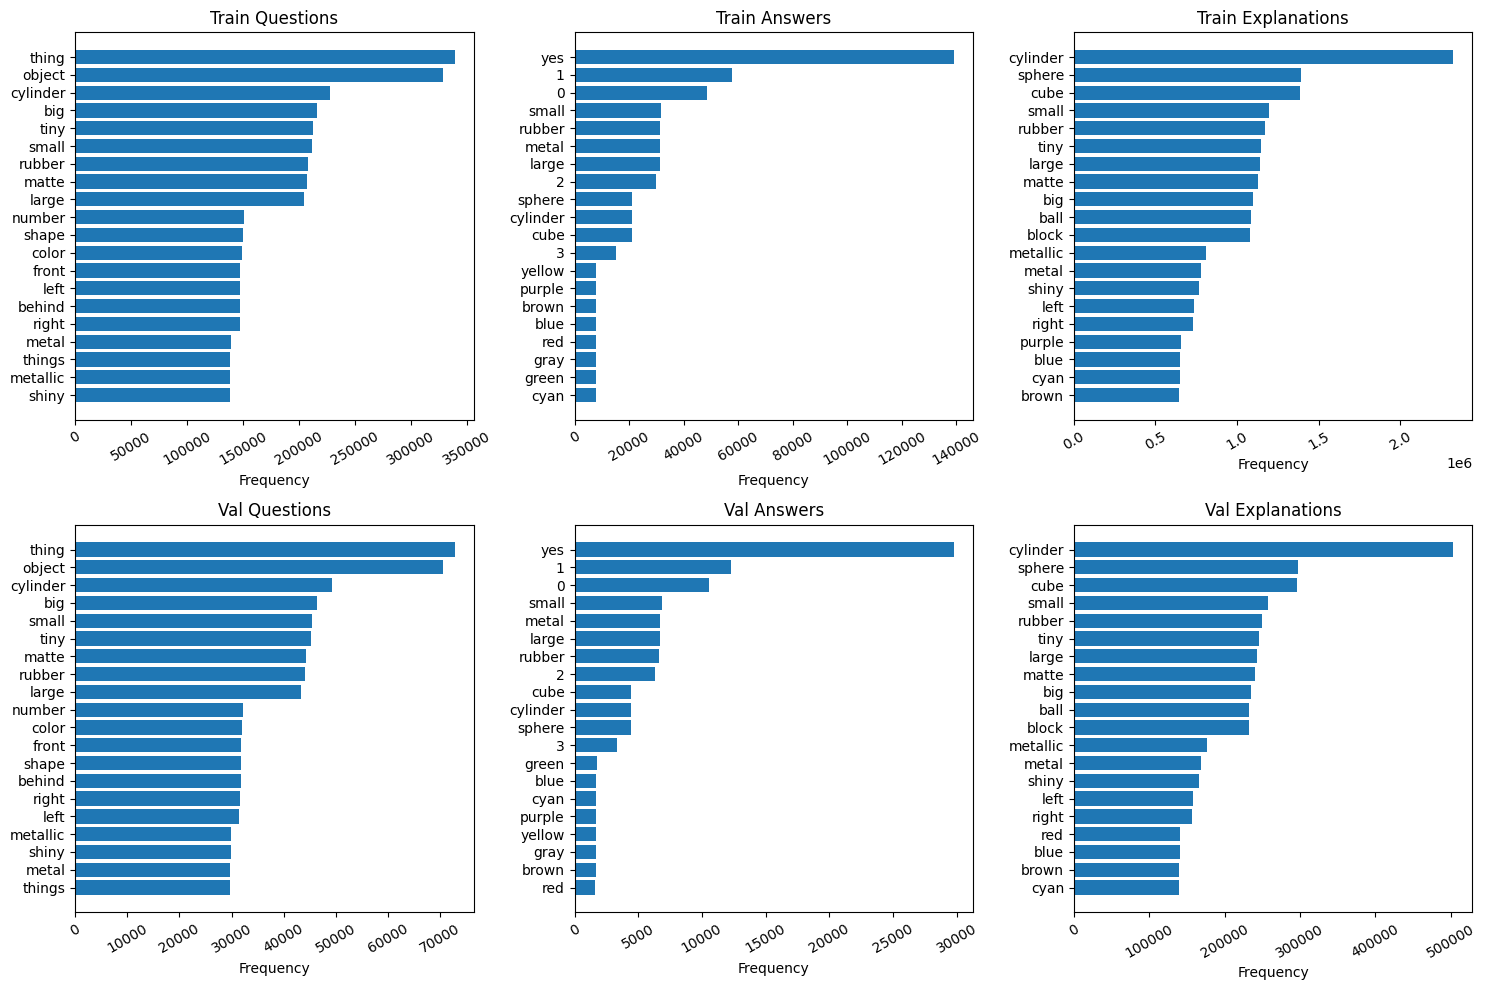

Unique english words in train questions: 52
Unique english words in train answers: 27
Unique english words in train explanations: 47
Unique english words in val questions: 52
Unique english words in val answers: 27
Unique english words in val explanations: 47


In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plot_word_frequency(axes[0, 0], vocab_questions_train_eng, 'Train Questions')
plot_word_frequency(axes[0, 1], vocab_answers_train_eng, 'Train Answers')
plot_word_frequency(axes[0, 2], vocab_explanations_train_eng, 'Train Explanations')

plot_word_frequency(axes[1, 0], vocab_questions_val_eng, 'Val Questions')
plot_word_frequency(axes[1, 1], vocab_answers_val_eng, 'Val Answers')
plot_word_frequency(axes[1, 2], vocab_explanations_val_eng, 'Val Explanations')

plt.tight_layout()
plt.show()

print(f"Unique english words in train questions: {len(vocab_questions_train_eng)}")
print(f"Unique english words in train answers: {len(vocab_answers_train_eng)}")
print(f"Unique english words in train explanations: {len(vocab_explanations_train_eng)}")
print('='*40)
print(f"Unique english words in val questions: {len(vocab_questions_val_eng)}")
print(f"Unique english words in val answers: {len(vocab_answers_val_eng)}")
print(f"Unique english words in val explanations: {len(vocab_explanations_val_eng)}")


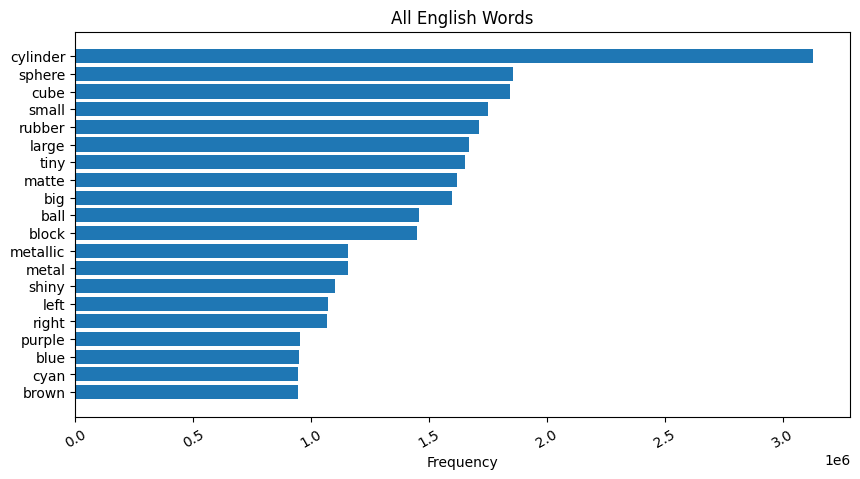

Unique english words in all: 72


In [8]:
all_eng_vocab = vocab_questions_train_eng + vocab_answers_train_eng + vocab_explanations_train_eng + vocab_questions_val_eng + vocab_answers_val_eng + vocab_explanations_val_eng

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_word_frequency(ax, all_eng_vocab, 'All English Words', top_n=20)

plt.show()

print(f"Unique english words in all: {len(all_eng_vocab)}")

In [22]:
eng_vocab ={
    'train':{
        'questions': vocab_questions_train_eng,
        'answers': vocab_answers_train_eng,
        'explanations': vocab_explanations_train_eng
    },
    'val':{
        'questions': vocab_questions_val_eng,
        'answers': vocab_answers_val_eng,
        'explanations': vocab_explanations_val_eng
    }
}
# Save the vocabulary
with open(os.path.join(clevrx_dir, 'eng_vocab.json'), 'w') as f:
    json.dump(eng_vocab, f, indent=4)

## Visualize data samples

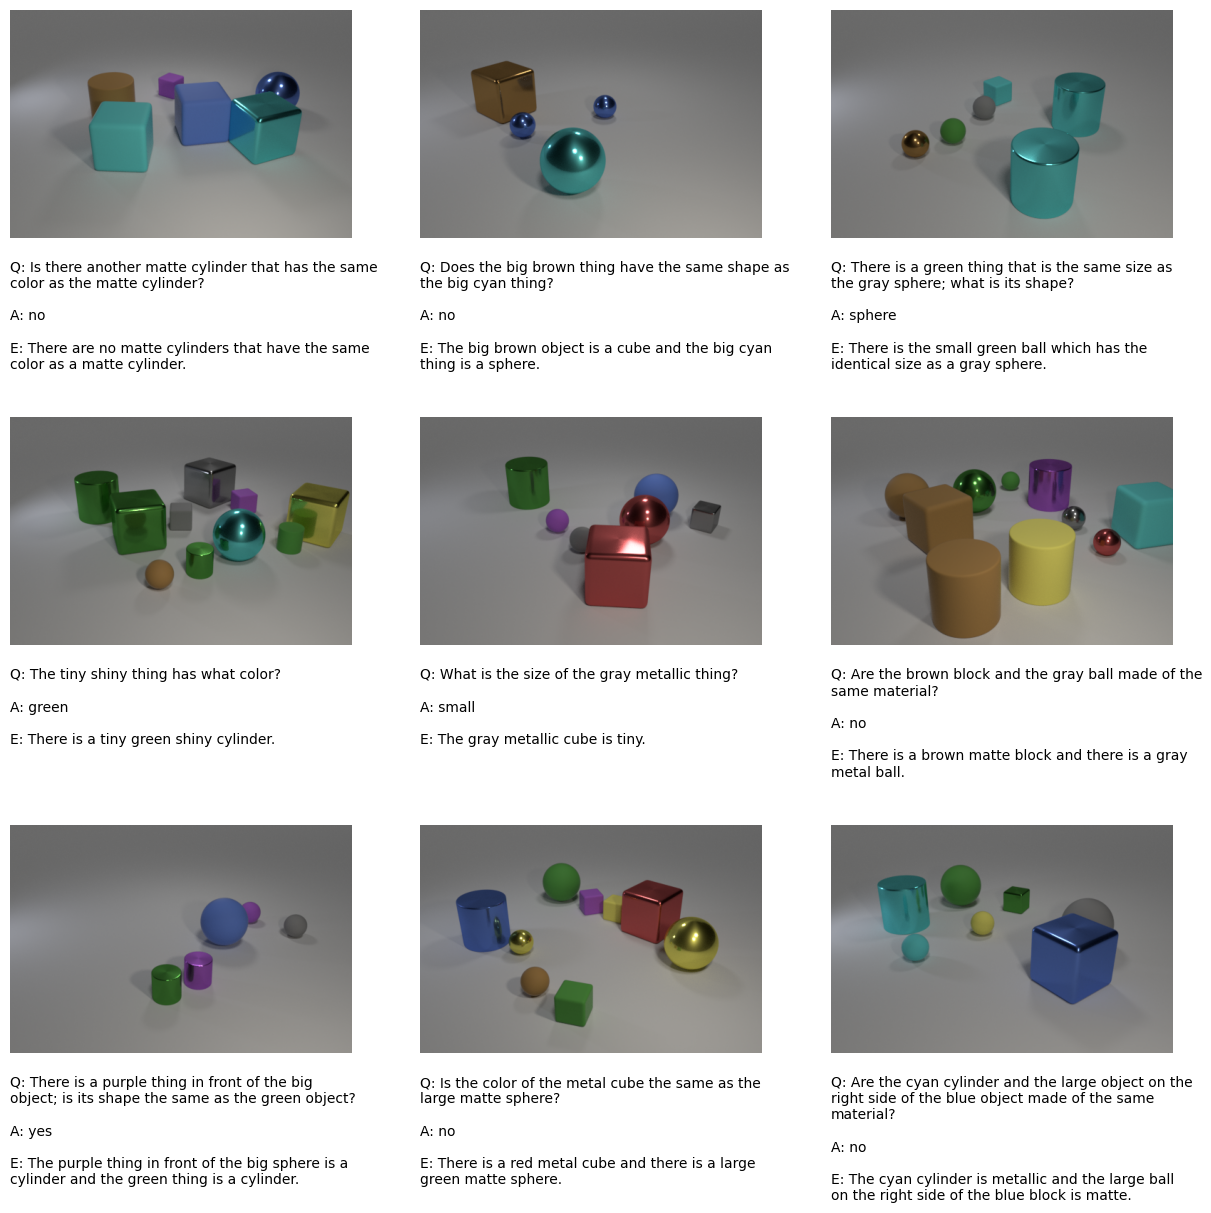

In [12]:
import textwrap

def visualize_samples(explain_data, image_dir, n_rows, n_cols):
    n_samples = n_rows * n_cols
    indices = random.sample(range(len(explain_data)), n_samples)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    if n_samples == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        row = i // n_cols
        col = i % n_cols
        
        data = explain_data[idx]
        img = Image.open(os.path.join(image_dir, data['image_filename']))
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        
        # Wrap text based on a fixed character width
        wrap_width = 50  # Adjust this value as needed
        question = textwrap.fill(data['question'], width=wrap_width)
        answer = textwrap.fill(data['answer'], width=wrap_width)
        explanation = textwrap.fill(data['factual_explanation'][0], width=wrap_width)
        
        text = f"Q: {question}\n\nA: {answer}\n\nE: {explanation}"
        axes[row, col].text(0, -0.1, text, verticalalignment='top', 
                            horizontalalignment='left', fontsize=10, 
                            transform=axes[row, col].transAxes,
                            wrap=True)
    
    for i in range(n_samples, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].axis('off')
    
    # plt.tight_layout()
    plt.show()

visualize_samples(explain_data, train_image_dir, 3, 3)

In [ ]:
def visualize_sample(explain_data, idx, image_dir, n_cols=5):
    data = explain_data[idx]
    img = Image.open(os.path.join(image_dir, data['image_filename']))
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 5))
    ax.imshow(img)
    ax.axis('off')
    
    wrap_width = 60  # Adjust this value as needed
    question = textwrap.fill(data['question'], width=wrap_width)
    answer = textwrap.fill(data['answer'], width=wrap_width)
    # string of explanations
    explanation = '\n\n'.join([textwrap.fill(exp, width=wrap_width) for exp in data['factual_explanation']])
    
    text = f"Q: {question}\n\nA: {answer}\n\nE: {explanation}"
    ax.text(0, -0.1, text, verticalalignment='top', 
            horizontalalignment='left', fontsize=7, 
            transform=ax.transAxes,
            wrap=True)

    plt.show()
    
visualize_sample(explain_data, 12, train_image_dir, n_cols=5)